In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [14]:
np.random.seed(347)
class MySuperGame:

  def __init__(self, BS):
    self.reset()
    np.random.seed(47)

    self.rewards={}
    for i in range(1,3):
      for j in range(-i,i+1,1):
        self.rewards[(i,j)] = np.random.randint(20)

  
  def reset(self):
    self.state = np.zeros([BS, 2], dtype = np.int32) # tuple, (time, location)
    self.time = 0

  def step(self, action): # action + 1, 0, -1     UP / STAY / DOWN <- action vector of size "BS" Batch-Size
    if self.time >= 2:
      return None
    self.time += 1
    self.state[:,0] += 1
    self.state[:,1] += action

    r = [game.rewards[si[0],si[1]] for si in self.state]

    return self.state+0.0, r, self.time < 2
    ####

BS = 4
game = MySuperGame(BS)
# print (game.state)
action = np.array([+1, -1, 0, +1])
game.step(action)
action = np.array([1, +1, -1, 0])
s, r, flag = game.step(action)
s, r, flag
# # game.step(None)
# # print (game.state)
# # game.step(None)
# print (game.state)
# action = np.array([-1, +1, +1, 0])
# # game.step(action)
# print (game.state)
# game.rewards
# [ time, location]
# [0,0] -> UP -> [1,1] -> STAY -> [ 2, 1 ]

(array([[ 2.,  2.],
        [ 2.,  0.],
        [ 2., -1.],
        [ 2.,  1.]]), [16, 19, 8, 16], False)

In [20]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.Activation = F.leaky_relu
    self.FC1 = nn.Linear( 2, 8  )
    self.FC2 = nn.Linear( 8, 8  )
    self.FC3 = nn.Linear( 8, 3  )

  def forward(self,x):
    x = F.leaky_relu(self.FC1(x))
    x = F.leaky_relu(self.FC2(x))
    x = self.FC3(x)
    prob = F.softmax( x, dim =1)
    return prob

game.reset()
torch.manual_seed(347)
actor = Actor()

action = np.array([1, +1, -1, 0])
s, r, flag = game.step(action)
# game.state
actor(torch.Tensor(s))

tensor([[0.4178, 0.2469, 0.3352],
        [0.4178, 0.2469, 0.3352],
        [0.4514, 0.2558, 0.2927],
        [0.4484, 0.2472, 0.3044]], grad_fn=<SoftmaxBackward>)

In [16]:
game.reset()
probs = actor(torch.Tensor(game.state))
probs

tensor([[0.4256, 0.2728, 0.3016],
        [0.4256, 0.2728, 0.3016],
        [0.4256, 0.2728, 0.3016],
        [0.4256, 0.2728, 0.3016]], grad_fn=<SoftmaxBackward>)

In [17]:
BS = 4
game = MySuperGame(BS)
game.reset()
probs = actor(torch.Tensor(game.state))
print(probs)
m = Categorical(probs)
action = m.sample()
# action
#m.log_prob(action), torch.log(probs)

tensor([[0.4256, 0.2728, 0.3016],
        [0.4256, 0.2728, 0.3016],
        [0.4256, 0.2728, 0.3016],
        [0.4256, 0.2728, 0.3016]], grad_fn=<SoftmaxBackward>)


In [23]:
def rollout(actor, game):
  game.reset()
  notDone = True

  log_probs = []
  rewards = []
  while notDone: 

    probs = actor(torch.Tensor(game.state))
    m = Categorical(probs)
    action = m.sample()

    log_probs.append(m.log_prob(action))

    s, r, notDone = game.step(action.data.int().numpy()-1)
    rewards.append(r)

  return log_probs, rewards  

log_probs, rewards = rollout(actor, game)
log_probs, rewards
np.mean(np.sum(rewards,0))

21.75

In [24]:
log_probs

[tensor([-1.1986, -1.1986, -0.8542, -1.1986], grad_fn=<SqueezeBackward1>),
 tensor([-1.3986, -1.0930, -0.7953, -0.8726], grad_fn=<SqueezeBackward1>)]

In [25]:
torch.stack(log_probs)

tensor([[-1.1986, -1.1986, -0.8542, -1.1986],
        [-1.3986, -1.0930, -0.7953, -0.8726]], grad_fn=<StackBackward>)

In [26]:
torch.sum(torch.stack(log_probs),0)

tensor([-2.5972, -2.2916, -1.6495, -2.0712], grad_fn=<SumBackward1>)

In [30]:
torch.mean(torch.tensor(R)*logProbSum)

tensor(-0.6682, grad_fn=<MeanBackward0>)

26.0

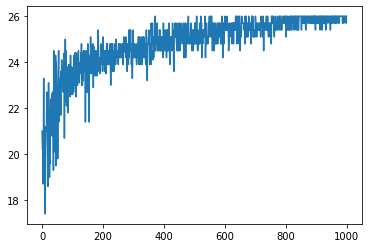

In [27]:
BS = 10
game = MySuperGame(BS)

torch.manual_seed(347)
actor = Actor()
actor_optim = optim.Adam(actor.parameters(), lr=1e-2)

rewardHistory = []

for it in range(1000):
  log_probs, rewards = rollout(actor, game)
  R = np.sum(np.array(rewards),0)
#  print (R)
  rewardHistory.append(np.mean(R))

  logProbSum = torch.sum(torch.stack(log_probs),0)
  actor_loss = -torch.mean(torch.tensor(R)*logProbSum)

  actor_optim.zero_grad()
  actor_loss.backward()
  actor_optim.step()

plt.plot(rewardHistory)
np.max(rewardHistory)

In [28]:
for w in actor.parameters():
  print(w.grad)

tensor([[-7.5756e-02, -7.5756e-02],
        [ 3.4367e-04,  3.4367e-04],
        [ 6.5080e-04,  6.5080e-04],
        [-1.3545e-01, -1.3545e-01],
        [ 1.3077e-04,  1.3077e-04],
        [-1.2555e-01, -1.2555e-01],
        [-1.4735e-01, -1.4735e-01],
        [-9.6918e-02, -9.6918e-02]])
tensor([-0.0848, -0.0106,  0.0008, -0.1012, -0.0157, -0.1294, -0.1654, -0.0926])
tensor([[ 5.9449e-03, -1.9368e-05, -2.0963e-05,  2.1962e-02, -3.8541e-05,
          1.4266e-02,  7.6746e-03,  2.4825e-02],
        [-2.0752e-03, -1.4461e-03,  2.2544e-05,  1.0467e-02, -2.9581e-03,
          1.9811e-03, -1.7836e-03,  1.0098e-02],
        [-2.7034e-03, -2.2299e-03,  3.2994e-05,  1.7955e-02, -4.5613e-03,
          4.2386e-03, -2.1103e-03,  1.7624e-02],
        [-3.0703e-03, -7.6451e-04,  1.8943e-05, -1.6759e-03, -1.5642e-03,
         -3.6571e-03, -3.4863e-03, -2.8186e-03],
        [ 2.5764e-02, -6.3770e-05, -9.1058e-05,  9.4927e-02, -1.2578e-04,
          6.1729e-02,  3.3247e-02,  1.0733e-01],
        [-1.206

In [29]:
game.reset()
actor(torch.Tensor(game.state))

tensor([[1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01],
        [1.4375e-04, 2.0339e-05, 9.9984e-01]], grad_fn=<SoftmaxBackward>)